In [1]:
using Pkg
Pkg.activate("/home/julisn/Codes/LadderDGA.jl/")
using LadderDGA
using Plots, LaTeXStrings

  Activating project at `~/Codes/LadderDGA.jl`


In [15]:
cfg = "/home/julisn/Hamburg/ED_data/asympt_tests/b5.0_mu1.4_tp0_5.toml"
wp, mP, sP, env, kGridsStr = readConfig(cfg)
lDGAhelper = setup_LDGA(kGridsStr[1], mP, sP, env)
lDGAhelper_Ur = deepcopy(lDGAhelper)
lDGAhelper_Ur.Γ_m[:,:,:] = lDGAhelper_Ur.Γ_m[:,:,:] .- (-lDGAhelper_Ur.mP.U / lDGAhelper_Ur.mP.β^2)
lDGAhelper_Ur.Γ_d[:,:,:] = lDGAhelper_Ur.Γ_d[:,:,:] .- ( lDGAhelper_Ur.mP.U / lDGAhelper_Ur.mP.β^2)

bubble     = calc_bubble(lDGAhelper);

[ Info: Reading Inputs...
[ Info: Setting up calculation for kGrid 2Dsc-0.25-0.125-0.0 of size 2
┌ Warning: Using plain summation for λ₀, check Σ_ladder tails!
└ @ LadderDGA ~/Codes/LadderDGA.jl/src/BSETools.jl:104
┌ Info: Inputs Read. Starting Computation.
│ Local susceptibilities with ranges are:
│ χLoc_m(94:108) = 0.3933, χLoc_d(94:108) = 0.0825
└ sum χupup check (plain ?≈? tail sub ?≈? imp_dens ?≈? n/2 (1-n/2)): 0.2300928960488818 ?=? 0.23790810368053422 ?≈? 0.23790810368053417 ≟ 0.24702998215472974"


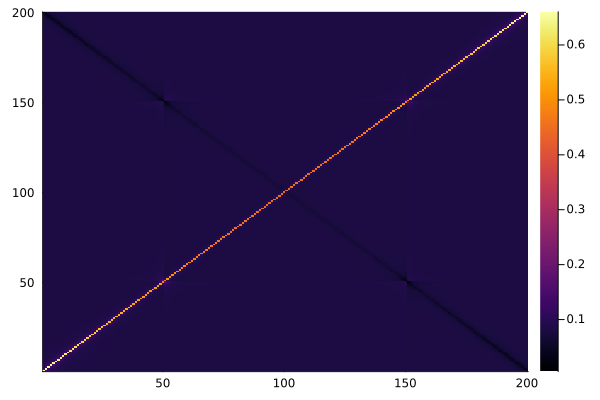

In [25]:
heatmap(real(lDGAhelper.Γ_d[:,:,1]))

In [3]:
χm, γm = calc_χγ(:m, lDGAhelper, bubble);
#χd, γd = calc_χγ(:d, lDGAhelper, bubble)
#λ₀ = calc_λ0(bubble, lDGAhelper)
#Σ_ladder = calc_Σ(χm, γm, χd, γd, λ₀, lDGAhelper);

[ Info: m channel: |∑χ(q=0,ω≠0)| = 0.42301267414 ≟ 0


In [4]:
#χm_star, γm_star = calc_χγ(:m, lDGAhelper_Ur, bubble)
#χd_star, γd_star = calc_χγ(:d, lDGAhelper_Ur, bubble);

# Matrix identity for difference between chi and chi^star


Let A and (A+B) be invertible matrices and rank(B) = 1. Then (see lDGA numerics):

$(A+B)^{-1} = A^{-1} - \frac{1}{1+g} A^{-1} B A^{-1}$ and $g = Tr(B A^{1}) \neq 1$



In [5]:
using LinearAlgebra
χm_gen      = calc_gen_χ(lDGAhelper.Γ_m, bubble, lDGAhelper.kG);
χm_star_gen = calc_gen_χ(lDGAhelper_Ur.Γ_m, bubble, lDGAhelper_Ur.kG);

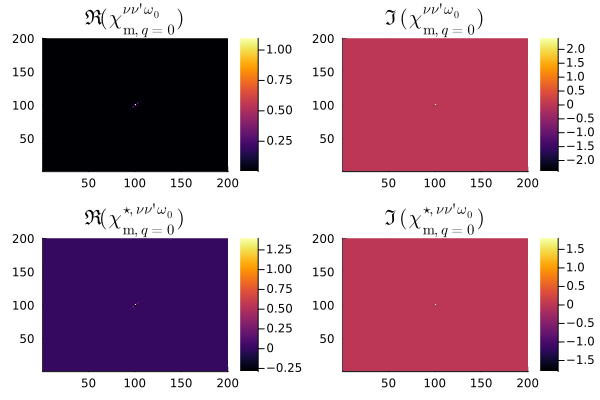

In [6]:
p1 = heatmap(real.(χm_gen[:,:,1,101]), 
    title=L"\Re(\chi^{\nu\nu'\omega_0}_{\mathrm{m},q=0})")
p2 = heatmap(imag.(χm_gen[:,:,1,101]), 
    title=L"\Im(\chi^{\nu\nu'\omega_0}_{\mathrm{m},q=0})")
p3 = heatmap(real.(χm_star_gen[:,:,1,101]), 
    title=L"\Re(\chi^{\star,\nu\nu'\omega_0}_{\mathrm{m},q=0})")
p4 = heatmap(imag.(χm_star_gen[:,:,1,101]), 
    title=L"\Im(\chi^{\star,\nu\nu'\omega_0}_{\mathrm{m},q=0})")

plot(p1, p2, p3, p4)

# Calculation of F_r

$ F^{\nu\nu'\omega}_{r,\mathbf{q}} = \beta^2 (\chi^{\nu\nu'\omega}_{0,\mathbf{q}})^{-1} 
            -  \beta^2 (\chi^{\nu\omega}_0)^{-1} \chi^{*,\nu\nu'\omega}_{r,\mathbf{q}} (\chi^{\nu'\omega}_0)^{-1} 
        + U_r (1 - U_r \chi^{\omega}_r) (\chi^{\nu\omega}_{0,\mathbf{q}})^{-1} \sum_{\nu_1\nu_2}\chi^{*,\nu\nu_1\omega}_{r,\mathbf{q}} \chi^{*,\nu_2\nu'\omega}_{r,\mathbf{q}} (\chi^{\nu'\omega}_{0,\mathbf{q}})^{-1} $
        
$ F^{\nu\nu'\omega}_{r,\mathbf{q}} = 
            \beta^2 (\chi^{\nu\nu'\omega}_{0,\mathbf{q}})^{-1}
            -  \beta^2 (\chi^{\nu\omega}_{0,\mathbf{q}})^{-1} \chi^{*,\nu\nu'\omega}_{r,\mathbf{q}} (\chi^{\nu'\omega}_{0,\mathbf{q}})^{-1} 
        + U_r (1 - U_r \chi^{\omega}_r) \gamma^{\nu\omega}_r \gamma^{\nu'\omega}_r $
        
$ F^{\nu\nu'\omega}_{r,\mathbf{q}} =
        \beta^2 \left( \chi^{\nu\nu'\omega}_{0,\mathbf{q}} \right)^{-1} 
        -  \beta^2 \left( \chi^{\nu\omega}_{0,\mathbf{q}} \right)^{-1}  \chi^{\nu\nu'\omega}_{r,\mathbf{q}} \left( \chi^{\nu'\omega}_{0,\mathbf{q}} \right)^{-1} $

In [7]:
function core(χ₀::χ₀T)
    view(χ₀.data, :,χ₀.ν_shell_size+1:size(χ₀.data,2)-χ₀.ν_shell_size,:)
end

function F_from_χ_star_gen_test(χ₀::χ₀T, χstar_r::Array{ComplexF64,4}, χr::χT, γr::γT, Ur::Float64)
    F = similar(χstar_r)
    for ωi in 1:size(χstar_r,4)
        for qi in 1:size(χstar_r,3)
            for νpi in 1:size(χstar_r,2)
                for νi in 1:size(χstar_r,1)
            F[νi,νpi,qi,ωi] =  - χ₀.β^2 .* χstar_r[νi,νpi,qi,ωi] ./ (core(χ₀)[qi,νi,ωi] * core(χ₀)[qi,νpi,ωi])
            F[νi,νpi,qi,ωi] += χ₀.β^2 .*  Ur * (1 - Ur * χr[qi,ωi]) .* (γr[qi,νi,ωi] .* γr[qi,νpi,ωi])
        
                end
                F[νpi,νpi,qi,ωi] += χ₀.β^2 / core(χ₀)[qi,νpi,ωi]
            end
        end
    end
    return F
end

function F_r_test(χ₀::χ₀T, χr)
    F = -deepcopy(χr)
    for ωi in 1:size(χm_gen,4)
        for qi in 1:size(χm_gen,3)
            for νpi in 1:size(χm_gen,2)
                for νi in 1:size(χm_gen,1)
                    F[νi,νpi,qi,ωi] = χ₀.β^2 .* F[νi,νpi,qi,ωi]/(core(χ₀)[qi,νi,ωi] * core(χ₀)[qi,νpi,ωi])
                end
                F[νpi,νpi,qi,ωi] += χ₀.β^2 / core(χ₀)[qi,νpi,ωi]
            end
        end
    end
    return F
end

function F_from_χ_gen_nb(χ₀::χ₀T, χr::Array{ComplexF64,4})::Array{ComplexF64,4}
    F = similar(χr)
    for ωi in 1:size(χr,4)
        for qi in 1:size(χr,3)
            F[:,:,qi,ωi] = Diagonal(χ₀.β^2 ./ core(χ₀)[qi,:,ωi]) .- χ₀.β^2 .* χr[:,:,qi,ωi] ./ ( core(χ₀)[qi,:,ωi] .* transpose(core(χ₀)[qi,:,ωi]))
        end
    end
    return F
end

function F_from_χ_star_gen(χ₀::χ₀T, χstar_r::Array{ComplexF64,4}, χr::χT, γr::γT, Ur::Float64)
    F = similar(χstar_r)
    for ωi in 1:size(χstar_r,4)
        for qi in 1:size(χstar_r,3)
            F[:,:,qi,ωi] = Diagonal(χ₀.β^2 ./ core(χ₀)[qi,:,ωi]) .- χ₀.β^2 .* χstar_r[:,:,qi,ωi] ./ (core(χ₀)[qi,:,ωi] .* transpose(core(χ₀)[qi,:,ωi]))
            F[:,:,qi,ωi] +=  Ur * (1 - Ur * χr[qi,ωi]) .* (γr[qi,:,ωi] .* transpose(γr[qi,:,ωi]))
        end
    end
    return F
end

F_from_χ_star_gen (generic function with 1 method)

In [8]:
@time F_m_test3 = F_from_χ_star_gen(bubble, χm_star_gen, χm, γm, -lDGAhelper_Ur.mP.U)

  0.929792 seconds (10.86 k allocations: 2.168 GiB, 9.23% gc time)


200×200×3×201 Array{ComplexF64, 4}:
[:, :, 1, 1] =
 -1.61264+0.027361im    -1.75183+0.00569389im  …  -1.66588-4.23661e-7im
 -1.75183+0.00569389im  -1.70421+0.0274948im      -1.79702-0.176187im
 -1.84338+0.00470856im  -1.75987+0.00566768im     -1.89466-0.180668im
 -1.90066+0.00415347im  -1.84783+0.00468583im      -1.9398-0.156256im
 -1.93316+0.00384758im  -1.90341+0.00413533im     -1.96169-0.132924im
 -1.95268+0.00366661im    -1.935+0.00383227im  …  -1.97357-0.114008im
  -1.9651+0.00355171im  -1.95398+0.00365304im     -1.98067-0.0989992im
 -1.97339+0.00347442im  -1.96605+0.00353931im     -1.98523-0.0870162im
 -1.97915+0.00341991im  -1.97411+0.00346283im     -1.98833-0.0773242im
 -1.98329+0.00337995im  -1.97971+0.00340892im     -1.99052-0.069373im
 -1.98634+0.00334968im  -1.98373+0.00336943im  …  -1.99213-0.0627597im
 -1.98864+0.00332612im  -1.98669+0.00333953im     -1.99334-0.0571893im
 -1.99042+0.00330734im  -1.98893+0.00331628im     -1.99427-0.0524432im
         ⋮                     

In [9]:
@time F_m_test2 = F_from_χ_gen(bubble, χm_gen)

  0.743835 seconds (5.43 k allocations: 1.086 GiB, 6.75% gc time)


200×200×3×201 Array{ComplexF64, 4}:
[:, :, 1, 1] =
 -1.61264+0.027361im    -1.75183+0.00569389im  …  -1.66588-4.23663e-7im
 -1.75183+0.00569389im  -1.70421+0.0274948im      -1.79702-0.176187im
 -1.84338+0.00470856im  -1.75987+0.00566768im     -1.89466-0.180668im
 -1.90066+0.00415347im  -1.84783+0.00468583im      -1.9398-0.156256im
 -1.93316+0.00384758im  -1.90341+0.00413533im     -1.96169-0.132924im
 -1.95268+0.00366661im    -1.935+0.00383227im  …  -1.97357-0.114008im
  -1.9651+0.00355171im  -1.95398+0.00365304im     -1.98067-0.0989992im
 -1.97339+0.00347442im  -1.96605+0.00353931im     -1.98523-0.0870162im
 -1.97915+0.00341991im  -1.97411+0.00346283im     -1.98833-0.0773242im
 -1.98329+0.00337995im  -1.97971+0.00340892im     -1.99052-0.069373im
 -1.98634+0.00334968im  -1.98373+0.00336943im  …  -1.99213-0.0627597im
 -1.98864+0.00332612im  -1.98669+0.00333953im     -1.99334-0.0571893im
 -1.99042+0.00330734im  -1.98893+0.00331628im     -1.99427-0.0524432im
         ⋮                     

In [10]:
@time F_m_test1 = F_r_test(bubble, χm_gen)

 19.890619 seconds (242.36 M allocations: 7.592 GiB, 4.55% gc time, 1.24% compilation time)


200×200×3×201 Array{ComplexF64, 4}:
[:, :, 1, 1] =
 -1.61264+0.027361im    -1.75183+0.00569389im  …  -1.66588-4.23663e-7im
 -1.75183+0.00569389im  -1.70421+0.0274948im      -1.79702-0.176187im
 -1.84338+0.00470856im  -1.75987+0.00566768im     -1.89466-0.180668im
 -1.90066+0.00415347im  -1.84783+0.00468583im      -1.9398-0.156256im
 -1.93316+0.00384758im  -1.90341+0.00413533im     -1.96169-0.132924im
 -1.95268+0.00366661im    -1.935+0.00383227im  …  -1.97357-0.114008im
  -1.9651+0.00355171im  -1.95398+0.00365304im     -1.98067-0.0989992im
 -1.97339+0.00347442im  -1.96605+0.00353931im     -1.98523-0.0870162im
 -1.97915+0.00341991im  -1.97411+0.00346283im     -1.98833-0.0773242im
 -1.98329+0.00337995im  -1.97971+0.00340892im     -1.99052-0.069373im
 -1.98634+0.00334968im  -1.98373+0.00336943im  …  -1.99213-0.0627597im
 -1.98864+0.00332612im  -1.98669+0.00333953im     -1.99334-0.0571893im
 -1.99042+0.00330734im  -1.98893+0.00331628im     -1.99427-0.0524432im
         ⋮                     

In [11]:
all(F_m_test1 .≈ F_m_test2)

true

In [12]:
F_m_loc = F_from_χ(lDGAhelper.χDMFT_m, lDGAhelper.gImp[1, :], lDGAhelper.sP, lDGAhelper.mP.β);

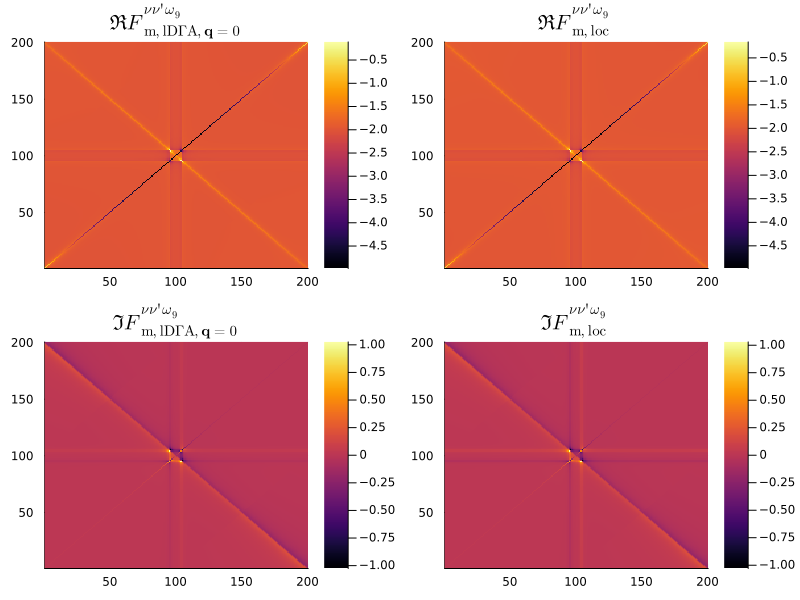

In [13]:
ωi = 110

ωn = (-lDGAhelper.sP.n_iω:lDGAhelper.sP.n_iω)[ωi]
p1 = heatmap(real(F_m_test2[:,:,1,ωi]), title=L"\Re F^{\nu\nu'\omega_{%$ωn}}_{\mathrm{m},\mathrm{lD}\Gamma\mathrm{A},\mathbf{q}=0}")
p2 = heatmap(real(F_m_loc[:,:,ωi]), title=L"\Re F^{\nu\nu'\omega_{%$ωn}}_{\mathrm{m},\mathrm{loc}}")
p3 = heatmap(imag(F_m_test2[:,:,1,ωi]), title=L"\Im F^{\nu\nu'\omega_{%$ωn}}_{\mathrm{m},\mathrm{lD}\Gamma\mathrm{A},\mathbf{q}=0}")
p4 = heatmap(imag(F_m_loc[:,:,ωi]), title=L"\Im F^{\nu\nu'\omega_{%$ωn}}_{\mathrm{m},\mathrm{loc}}")
plot(p1, p2, p3, p4, size=(800,600))